In [1]:
### TO-DOs ###

# Code a Monte Carlo simulation where each of the inputs is a distribution and the intrinsic index level is one too
# Plot the historical and projected trajectory with confidence intervals for each input
# Substitute each of hard-coded inputs for adequate cualculations
# Prepare this to be repeated at any point during the year and not just at year end (ttm calculations, etc.)

In [2]:
import requests
from urllib.parse import urlparse, urlunparse

import numpy as np
import numpy_financial as npf

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date


#financialmodellingprep.com API key
apikey = '6d5a44e82d49d8446e8db1914d12e2b4'
simfinkey = 'S54dNEScw70KAegQwNs46skHPfblWSoB'

In [3]:
valuation_date = date.fromisoformat('2020-06-01')
years_to_project = 5

monte_carlo_iterations = 1000

projected_years = [y for y in range(valuation_date.year,valuation_date.year+years_to_project)]
# Instead of years the dates should be 12 months from valuation date, and then 12 months later, etc.

## S&P500 Valuation
21 February 2021

#### Framework and key questions to answer
<img src="img/IndexValueFramework.jpg" width=360 align="left"/>

#### Story

---

**1. Earnings Growth**

**2. Cash Return**

**3. Risk Premium**

**4. Risk Free Rate**

In [4]:
hist_df = pd.read_excel('data/histimplERP.xls',sheet_name='Historical Impl Premiums',header=6,skipfooter=7)
hist_df.drop(hist_df.tail(1).index,inplace=True) #Temporary fix because using data file from 2021 and replicating valuation as if it was 2020

In [5]:
inputs_df = pd.DataFrame()
inputs_df['year'] = hist_df['Year']
inputs_df['ERP'] = hist_df['Implied Premium (FCFE)']
inputs_df['earnings'] = hist_df['Earnings*']
inputs_df['RFR'] = hist_df['T.Bond Rate']
inputs_df['div&bb'] = hist_df['Dividends + Buybacks']

# Keep adding historical values for all the other elements of the valuation

### Present the historical and projected for each input with the rational for projection

In [6]:
#cash_returned = np.array([0,90.71,121.01,137.93,156.66,177.37])

In [13]:
(hist_df['Dividends + Buybacks'] / hist_df['Earnings*']).mean()

0.8221724202453385

### Calculations

In [19]:
outputs_df = pd.DataFrame()

# Generate all the rndom variables at once to then use inside the iteration
ERP_random = np.random.uniform(5.02/100,6.14/100,monte_carlo_iterations)
percent_returned_first = 0.75
percent_returned_last = 0.82
#cash_returned_percent = np.array([0.75591667, 0.80673333, 0.85761363, 0.90843723, 0.95922341])

# What is below would be one iteration
for i in range(0,monte_carlo_iterations):
    # Estimates for all inputs - Need to intriduce randomness here -
    future_earnings = np.array([120,150,160.83,172.45,184.91])
    percent_returned = np.linspace (start=percent_returned_first,stop=percent_returned_last,num=years_to_project)
    cash_returned = future_earnings * percent_returned
#    cash_returned = np.array([90.71,121.01,137.93,156.66,177.37])
# equity_risk_premium = 5.58/100
    equity_risk_premium = ERP_random[i]
    risk_free_rate = 0.66/100

    discount_rate = risk_free_rate + 1 * equity_risk_premium
    long_term_growth = risk_free_rate

    #Calculate intrinsic value of the index given estimates for input
    cash_flows = np.concatenate((np.array([0]),cash_returned)) # Add a "today" cash flow of 0 to make first cash flow in year 1
    cash_terminal = cash_returned[-1]*(1+long_term_growth)/(discount_rate - long_term_growth)
    cash_flows[-1] += cash_terminal

    intrinsic_index_level = npf.npv(discount_rate,cash_flows)
    d = [{'S&P500': intrinsic_index_level}]
    outputs_df = outputs_df.append(d,ignore_index=True,sort=False)

    # Create rows for projection
    d = {'year': projected_years, 
         'earnings': future_earnings,
         'div&bb': cash_returned,
         'RFR': [risk_free_rate]*years_to_project,
         'ERP': [equity_risk_premium]*years_to_project,
        }
    temp_df = pd.DataFrame(d)
    
    # Append new projection to output_df
    inputs_df = pd.concat([inputs_df,temp_df])

### OUT

<AxesSubplot:xlabel='year', ylabel='ERP'>

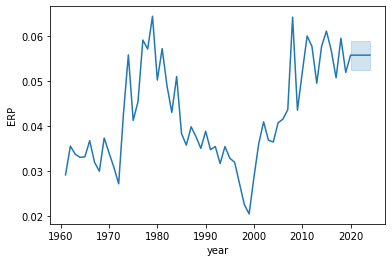

In [29]:
sns.lineplot(x="year", y="ERP",data=inputs_df,ci="sd")

<AxesSubplot:ylabel='S&P500'>

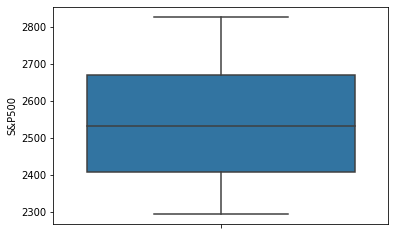

In [30]:
sns.boxplot(y="S&P500",
            data=outputs_df)

<AxesSubplot:xlabel='S&P500', ylabel='Count'>

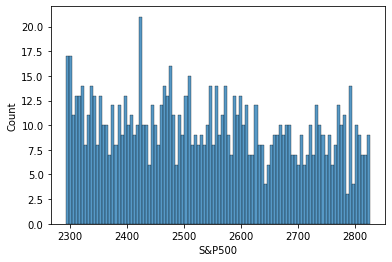

In [32]:
sns.histplot(data=outputs_df, x="S&P500", bins=100)